# Implement plateau potential in Neuron model

In [1]:
%matplotlib inline

from    neuron  import          h
import  numpy                as np
import  matplotlib.pyplot    as plt
import  matplotlib.image     as mpimg
import  json

from mpl_toolkits.axes_grid.inset_locator import inset_axes

# Load model mechanisms
import neuron               as nrn
nrn.load_mechanisms('Mech/')

h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')
    

1.0

## Single cell default values (no leak)

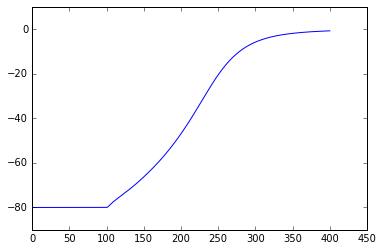

In [2]:
# simulation length
tstop = 400

# create cell
dend = h.Section(name='dend')

# max receptor current (uS). 
ampa_max = 5e-3                # ~10 ampa synapses in genesis model (1 = 510 pS)
nmda_max = 15e-2               # in genesis model 1 = 1410 ps

# insert receptors (activated after 100 ms)
ampa       = h.ampa(0.5, sec=dend)
ampa.onset = 100
ampa.gmax  = ampa_max
nmda       = h.nmda(0.5, sec=dend)
nmda.onset = 100
nmda.gmax  = nmda_max

# record vectors
vm = h.Vector()
vm.record(dend(0.5)._ref_v)
tm  = h.Vector()
tm.record(h._ref_t)

h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.figure()   
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### Adjust size of section (l=d=12.2 um)

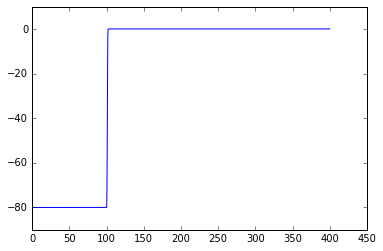

In [3]:

# UPDATED********************************************************
# size of dend
dend.L         = 12.2
dend(0.5).diam = 12.2
# ***************************************************************


h.finitialize(-80)
while h.t < tstop:
    h.fadvance()

plt.figure()
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### With leak

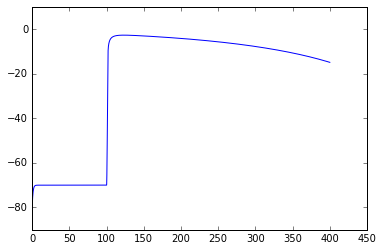

In [4]:


# UPDATED********************************************************
# insert pas
dend.insert('pas')
# ***************************************************************



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### Set (non default) values of leak

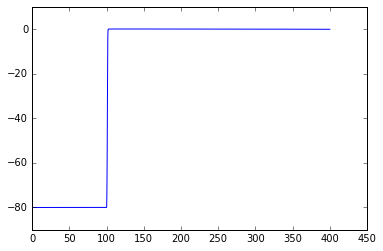

In [5]:


# UPDATED********************************************************
dend.g_pas = 1e-5
dend.e_pas = -80
dend.cm    = 1.0
dend.Ra    = 150
#****************************************************************



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### Weak synaptic activation (1 spine in the Genesis model)

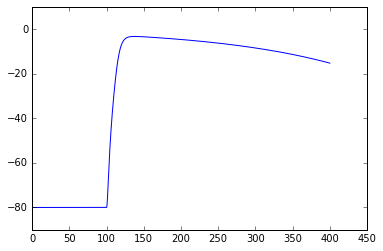

In [6]:


# max receptor current (uS)
# UPDATED********************************************************
ampa.gmax = 0.5e-3 
nmda.gmax = 1.5e-3 
# ***************************************************************



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### include ion channels (maximal conductance is same as at 115 um)

In [7]:
# calc channel gmax
def calculate_distribution(d3, dist, a4, a5,  a6,  a7, g8):
    '''
    Used for setting the maximal conductance of a segment.
    Scales the maximal conductance based on somatic distance and distribution type.
    
    Parameters:
    d3   = distribution type:
         0 linear, 
         1 sigmoidal, 
         2 exponential
         3 step function
    dist = somatic distance of segment
    a4-7 = distribution parameters 
    g8   = base conductance (similar to maximal conductance)
    
    '''
    
    if   d3 == 0: 
        value = a4 + a5*dist
    elif d3 == 1: 
        value = a4 + a5/(1 + np.exp((dist-a6)/a7) )
    elif d3 == 2: 
        value = a4 + a5*np.exp((dist-a6)/a7)
    elif d3 == 3:
        if (dist > a6) and (dist < a7):
            value = a4
        else:
            value = a5
            
    if value < 0:
        value = 0
        
    value = value*g8
    return value

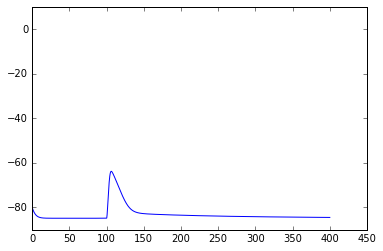

In [8]:


# UPDATED********************************************************
# insert ion channels
casc    =   h.D1_reduced_cascade2_0(0.5, sec=dend) 
pointer =   casc._ref_Target1p   

with open('params_dMSN.json') as file:
    par = json.load(file)

channels = [    "naf",      
                "kaf",
                "kas",
                "kdr",
                "kir",
                "cal12",
                "cal13",
                "can",
                "car",
                "cav32",
                "cav33",
                "cadyn", 
                "caldyn",
                "sk",
                "bk"            ]

for mech in channels:
    dend.insert(mech)

dist = 115.0

cmd = 'dend(0.5).gbar_naf = calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
exec(cmd)
cmd = 'dend(0.5).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
exec(cmd)   
cmd = 'dend(0.5).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
exec(cmd) 
cmd = 'dend(0.5).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
exec(cmd) 
cmd = 'dend(0.5).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
exec(cmd)
cmd = 'dend(0.5).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
exec(cmd)
cmd = 'dend(0.5).pbar_cal12 = 1e-5'
exec(cmd)
cmd = 'dend(0.5).pbar_cal13 = 1e-6'
exec(cmd)
cmd = 'dend(0.5).pbar_car = 1e-4'
exec(cmd)
cmd = 'dend(0.5).pbar_can = 1e-7'
exec(cmd)
cmd = 'dend(0.5).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
exec(cmd)
cmd = 'dend(0.5).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
exec(cmd)
    
    
for seg in dend:
    for mech in seg:
        if mech.name() in [ "kaf", \
                            "kas", \
                            "naf", \
                            "kir", \
                            "cal12", \
                            "cal13", \
                            "can"           ]:
            
            h.setpointer( pointer, 'pka', mech )

dend.ek  = -85
dend.ena =  50

# **********************************************************************************************



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### Increase conductances (to match new currents)
About same as total genesis activation (20)

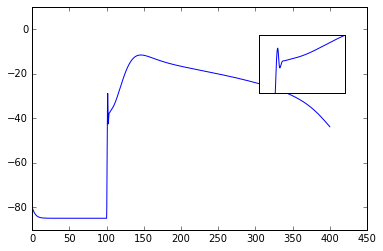

In [9]:


# max receptor current (uS). about same as total genesis activation (20)
# UPDATED********************************************************
ampa.gmax = 10e-3 
nmda.gmax = 30e-3 
# ***************************************************************



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
ax2 = plt.axes([.65, .6, .2, .2])
ax2.plot(tm,vm)
plt.setp(ax2, ylim=(-60, -20), xlim=(95,125), xticks=[], yticks=[])
plt.show()

## Add a somatic compartment

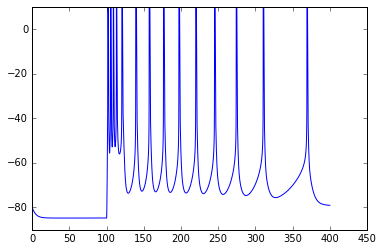

In [10]:



# UPDATED********************************************************
soma = h.Section(name='soma')

# size of soma
soma.L         = 12.2
soma(0.5).diam = 12.2

# insert pas
soma.insert('pas')
soma.g_pas = 1e-5
soma.e_pas = -80
soma.cm    = 1.0
soma.Ra    = 150

# insert ion channels
casc    =   h.D1_reduced_cascade2_0(0.5, sec=soma) 
pointer =   casc._ref_Target1p   

with open('params_dMSN.json') as file:
    par = json.load(file)

somaChan = [    "naf",      
                "kaf",
                "kas",
                "kdr",
                "kir",
                "cal12",
                "cal13",
                "can",
                "car",
                "cav32",
                "cav33",
                "cadyn", 
                "caldyn",
                "sk",
                "bk"            ]

for mech in somaChan:
    soma.insert(mech)

dist = 115.0

cmd = 'soma(0.5).gbar_naf = float(par["gbar_naf_somatic"]["Value"])'
exec(cmd)
cmd = 'soma(0.5).gbar_kaf = float(par["gbar_kaf_somatic"]["Value"])'
exec(cmd)   
cmd = 'soma(0.5).gbar_kas = float(par["gbar_kas_somatic"]["Value"])'
exec(cmd) 
cmd = 'soma(0.5).gbar_kir = float(par["gbar_kir_somatic"]["Value"])'
exec(cmd) 
cmd = 'soma(0.5).gbar_sk = float(par["gbar_sk_somatic"]["Value"])'
exec(cmd)
cmd = 'soma(0.5).gbar_bk = float(par["gbar_bk_somatic"]["Value"])'
exec(cmd)
cmd = 'soma(0.5).pbar_cal12 = 1e-5'
exec(cmd)
cmd = 'soma(0.5).pbar_cal13 = 1e-6'
exec(cmd)
cmd = 'soma(0.5).pbar_car = 1e-4'
exec(cmd)
cmd = 'soma(0.5).pbar_can = 1e-7'
    
    
for seg in soma:
    for mech in seg:
        if mech.name() in [ "kaf", \
                            "kas", \
                            "naf", \
                            "kir", \
                            "cal12", \
                            "cal13", \
                            "can"           ]:
            
            h.setpointer( pointer, 'pka', mech )


soma.ek  = -85.0
soma.ena  = 50.0

# connect the two compartments ------------------
dend.connect(soma(1))

# ***********************************************************************************

h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
plt.plot(tm,vm)
plt.ylim(-90, 10)
plt.show()

### Resize dendritc compartment and add a few more segments
**Also double the synaptic strength**

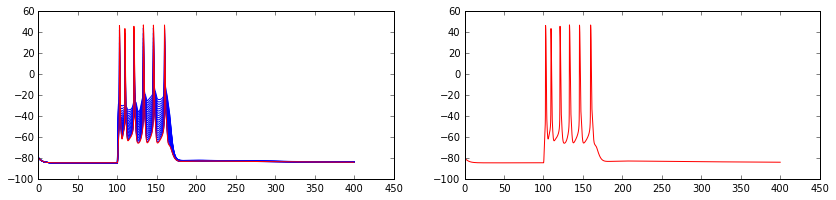

In [11]:

dend.L         = 230
dend.diam      = 1
dend.nseg      = 41
x              = 0.5
    
# insert pas
# dend.insert('pas')
# dend.g_pas = gpas
# dend.e_pas = Erev
# dend.cm    = Cm
# dend.Ra    = Ra

h.distance(sec=soma)
    
for mech in somaChan+["cav32", "cav33"]:
    dend.insert(mech)
    
# Set conductance and pointers (needed for dynamic neuromodulation; not used here).
for seg in dend:
    
    for mech in seg:
        if mech.name() in [ "kaf", \
                            "kas", \
                            "naf", \
                            "kir", \
                            "cal12", \
                            "cal13", \
                            "can"           ]:

            h.setpointer( pointer, 'pka', mech )
    
    dist = h.distance(seg.x, sec=dend)

    cmd = 'dend(seg.x).gbar_naf = calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
    exec(cmd)
    cmd = 'dend(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
    exec(cmd)   
    cmd = 'dend(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
    exec(cmd) 
    cmd = 'dend(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
    exec(cmd) 
    cmd = 'dend(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
    exec(cmd)
    cmd = 'dend(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_cal12 = 1e-5'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_cal13 = 1e-6'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_car = 1e-4'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_can = 1e-7'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
    exec(cmd)
    cmd = 'dend(seg.x).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
    exec(cmd)




# max receptor current (uS)
ampa_max = 20e-3 
nmda_max = 60e-3 

# insert receptors (activated after 100 ms)
ampa       = h.ampa(x, sec=dend)
ampa.onset = 100
ampa.gmax  = ampa_max
nmda       = h.nmda(x, sec=dend)
nmda.onset = 100
nmda.gmax  = nmda_max



# record vectors
vm = h.Vector()
vm.record(soma(0.5)._ref_v)
vmL = {}
for seg in dend:
    if seg.x > x:
        break
    vmL[seg.x] = h.Vector()
    vmL[seg.x].record(dend(seg.x)._ref_v)
tm  = h.Vector()
tm.record(h._ref_t)



h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
fig, ax = plt.subplots(1,2, figsize=(14,3))
for seg in dend:   
    if seg.x > x:
        break
    ax[0].plot(tm,vmL[seg.x], 'b')
for i in [0,1]:
    ax[i].plot(tm,vm, 'r')

plt.show()

### Since spiking; Not enough sink in soma -> add sink neurite

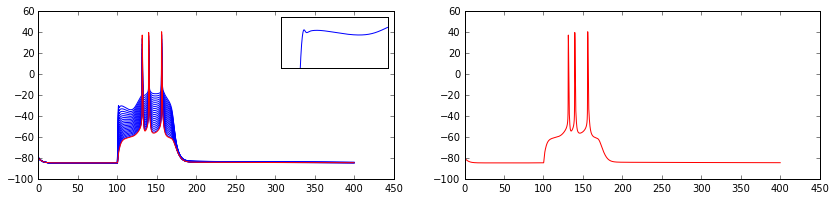

In [12]:

sink = h.Section(name='sink')
sink.connect(soma(1))

sink.L         = 230
sink.diam      = 3


# insert pas
sink.insert('pas')
sink.g_pas = 1e-5
sink.e_pas = -80
sink.cm    = 1.0
sink.Ra    = 150
        
for mech in somaChan+["cav32", "cav33"]:
    sink.insert(mech)
    
sink.ek  = -85
sink.ena =  50
    
# set pointers
for seg in sink:

    for mech in seg:
        if mech.name() in [ "kaf", \
                            "kas", \
                            "naf", \
                            "kir", \
                            "cal12", \
                            "cal13", \
                            "can"           ]:

            h.setpointer( pointer, 'pka', mech )
    
    dist = h.distance(seg.x, sec=sink)
    
    cmd = 'sink(seg.x).gbar_naf = calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
    exec(cmd)
    cmd = 'sink(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
    exec(cmd)   
    cmd = 'sink(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
    exec(cmd) 
    cmd = 'sink(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
    exec(cmd) 
    cmd = 'sink(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
    exec(cmd)
    cmd = 'sink(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cal12 = 1e-5'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cal13 = 1e-6'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_car = 1e-4'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_can = 1e-7'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
    exec(cmd)




h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
fig, ax = plt.subplots(1,2, figsize=(14,3))

for seg in dend:   
    if seg.x > x:
        break
    ax[0].plot(tm,vmL[seg.x], 'b')
    xL = seg.x
for i in [0,1]:
    ax[i].plot(tm,vm, 'r')
    
inset_ax = inset_axes(ax[0],
                      height="30%", 
                      width="30%", 
                      loc=1) 
inset_ax.plot(tm, vmL[xL], color='b')
plt.setp(inset_ax, ylim=(-60, -20), xlim=(95,125), xticks=[], yticks=[])

plt.show()


### Increasing diameter of sink (surface area)

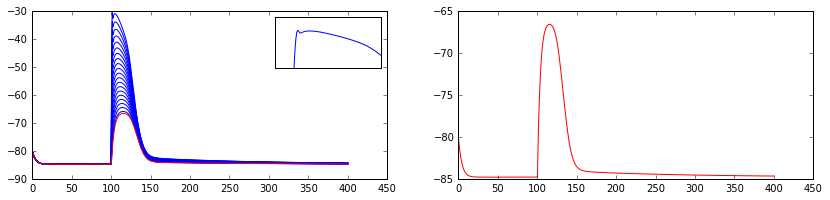

In [13]:

sink = h.Section(name='sink')
sink.connect(soma(1))

sink.L         = 230
sink.diam      = 5


# insert pas
sink.insert('pas')
sink.g_pas = 1e-5
sink.e_pas = -80
sink.cm    = 1.0
sink.Ra    = 150
        
for mech in somaChan+["cav32", "cav33"]:
    sink.insert(mech)
    
# set pointers
for seg in sink:

    for mech in seg:
        if mech.name() in [ "kaf", \
                            "kas", \
                            "naf", \
                            "kir", \
                            "cal12", \
                            "cal13", \
                            "can"           ]:

            h.setpointer( pointer, 'pka', mech )

sink.ek  = -85
sink.ena =  50
    



for seg in sink:
    
    dist = h.distance(seg.x, sec=sink)
    
    cmd = 'sink(seg.x).gbar_naf = calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
    exec(cmd)
    cmd = 'sink(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
    exec(cmd)   
    cmd = 'sink(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
    exec(cmd) 
    cmd = 'sink(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
    exec(cmd) 
    cmd = 'sink(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
    exec(cmd)
    cmd = 'sink(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cal12 = 1e-5'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cal13 = 1e-6'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_car = 1e-4'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_can = 1e-7'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
    exec(cmd)
    cmd = 'sink(seg.x).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
    exec(cmd)






h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
fig, ax = plt.subplots(1,2, figsize=(14,3))

for seg in dend:   
    if seg.x > x:
        break
    ax[0].plot(tm,vmL[seg.x], 'b')
    xL = seg.x
for i in [0,1]:
    ax[i].plot(tm,vm, 'r')

inset_ax = inset_axes(ax[0],
                      height="30%", # 
                      width="30%", 
                      loc=1) 
inset_ax.plot(tm, vmL[xL], color='b')
plt.setp(inset_ax, ylim=(-60, -20), xlim=(95,125), xticks=[], yticks=[])
plt.show()


### Record channel current in dendrite (x)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide


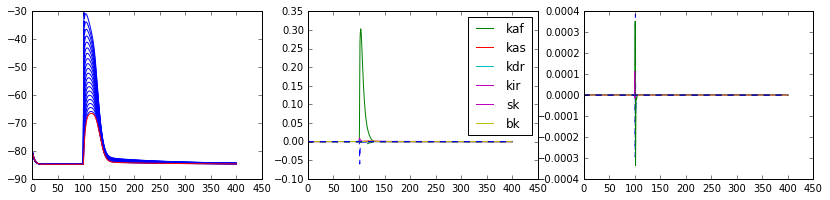

In [14]:
C = {}
for mech in somaChan+["cav32", "cav33"]:
    if mech in ["cadyn", "caldyn"]:
        continue
    C[mech] = h.Vector()
    cmd = 'C[mech].record(dend(x).'+mech+'._ref_I)'
    exec(cmd)
    
h.finitialize(-80)
while h.t < tstop:
    h.fadvance()
    
fig, ax = plt.subplots(1,3, figsize=(14,3))
for seg in dend:   
    if seg.x > x:
        break
    ax[0].plot(tm,vmL[seg.x], 'b')
ax[0].plot(tm,vm, 'r')

for mech in somaChan+["cav32", "cav33"]:
    if mech in ["cadyn", "caldyn"]:
        continue
    d1 = np.gradient(C[mech])
    d2 = np.gradient(d1)
    
    if mech[0] in ['n', 'c']:
        trace = np.divide(d1,max(d1))
        ls = '--'
        lw = 1
        label=''
    else:
        trace = np.divide(d1,min(d1))
        ls = '-'
        lw = 1
        label=mech
    ax[1].plot(tm, C[mech], label=label, ls=ls, lw=lw )
    ax[2].plot(tm, d2, label=label, ls=ls, lw=lw )
ax[1].legend()
plt.show()

## New synaptic channel

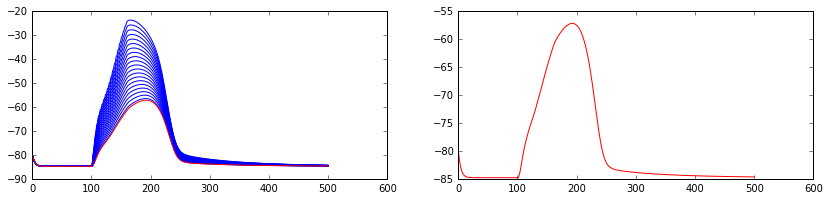

In [15]:

# delete old receptors
ampa = None
nmda = None

# add new receptors

# create synapse
x = 0.5
syn         = h.glutamate(x, sec=dend)
syn.ratio   = 1.0/3.0


# create NetStim object
stim            = h.NetStim()
stim.number     = 20
stim.start      = 100
stim.interval   = 1000/300 # mean interval between two spikes in ms (1000 / 300 Hz)
#stim.noise      = 1.0


#vecStim = h.VecStim()
#vec = h.Vector([100, 120])
#vecStim.play(vec)


# create NetCon object
#ncon             = h.NetCon(stim,syn) 
ncon             = h.NetCon(stim, syn)
ncon.delay       = 1
ncon.weight[0]   = 1.5e-3 # (uS) = 1.5 nS
#ncon.threshold   = 0.1


vm = h.Vector()
vm.record(soma(0.5)._ref_v)

vmL = {}
for seg in dend:
    if seg.x > x:
        break
    vmL[seg.x] = h.Vector()
    vmL[seg.x].record(dend(seg.x)._ref_v)

h.finitialize(-80)
while h.t < 500:
    h.fadvance()
    
fig, ax = plt.subplots(1,2, figsize=(14,3))
for seg in dend:   
    if seg.x > x:
        break
    ax[0].plot(tm,vmL[seg.x], 'b')
for i in [0,1]:
    ax[i].plot(tm,vm, 'r')
plt.show()

## Simplified model with one full branch and one sink branch
Activation triggered at the 0.7 segment in dend 6 of branch 10 in the genesis morphology (at about 112 $\mu$m).

5.80938781892 dend[0] 0.5
12.2782497106 dend[1] 0.5
14.177494365 dend[2] 0.5
15.590542102 dend[3] 0.5
23.3276683993 dend[4] 0.5
47.525914915 dend[5] 0.5
42.5671822694 dend[6] 0.1
65.9185117253 dend[6] 0.3
89.2698411813 dend[6] 0.5
112.621170637 dend[6] 0.7
135.972500093 dend[6] 0.9
30.4847703322 dend[7] 0.5
22.2199256429 dend[8] 0.5
19.707845038 dend[9] 0.5
38.1300006584 dend[10] 0.5
50.1770354819 dend[11] 0.5
70.5421883632 dend[12] 0.5
52.8510183772 dend[13] 0.5
54.7689996293 dend[14] 0.5
35.0318956527 dend[15] 0.166666666667
52.1397543728 dend[15] 0.5
69.2476130929 dend[15] 0.833333333333
18.2511467217 dend[16] 0.5
26.6957662396 dend[17] 0.5
33.2097116572 dend[18] 0.5
46.4456163359 dend[19] 0.5
45.3685012283 dend[20] 0.5
115.0 sink 0.5


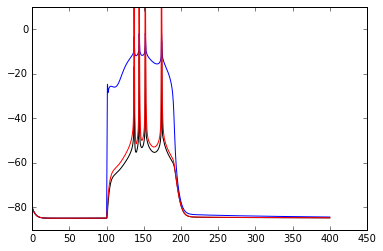

In [16]:
%reset -f

%matplotlib inline

from    neuron  import          h
import  numpy                as np
import  matplotlib.pyplot    as plt
import  matplotlib.image     as mpimg
import  json

from mpl_toolkits.axes_grid.inset_locator import inset_axes

# Load model mechanisms
import neuron               as nrn
nrn.load_mechanisms('Mech/')

h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')

vinit  = -80
tstop  = 400
use_Ca = True

def calculate_distribution(d3, dist, a4, a5,  a6,  a7, g8):
    '''
    Used for setting the maximal conductance of a segment.
    Scales the maximal conductance based on somatic distance and distribution type.
    
    Parameters:
    d3   = distribution type:
         0 linear, 
         1 sigmoidal, 
         2 exponential
         3 step function
    dist = somatic distance of segment
    a4-7 = distribution parameters 
    g8   = base conductance (similar to maximal conductance)
    
    '''
    
    if   d3 == 0: 
        value = a4 + a5*dist
    elif d3 == 1: 
        value = a4 + a5/(1 + np.exp((dist-a6)/a7) )
    elif d3 == 2: 
        value = a4 + a5*np.exp((dist-a6)/a7)
    elif d3 == 3:
        if (dist > a6) and (dist < a7):
            value = a4
        else:
            value = a5
            
    if value < 0:
        value = 0
        
    value = value*g8
    return value 




# import morphology (full stem; 8 or 10) --------------------------------------

Import = h.Import3d_SWC_read()
Import.input('stem10_msn_corrected.swc')
imprt = h.Import3d_GUI(Import, 0)
imprt.instantiate(None)
h.define_shape()


# make list of all dendritic sections
dendlist = h.SectionList()

for sec in h.allsec():
    dendlist.append(sec=sec)  
    
    
    
# create sink compartment and connect----------------------------------------

# get ref to soma sec (has no parent)
for sec in dendlist:
    sref = h.SectionRef(sec=sec)
    if not sref.has_parent():
        soma = sec
        break


sink        = h.Section(name='sink')
sink.L      = 230
sink.diam   = 3    

# connect sink to soma    
sink.connect(sec(0.5))
    
#h.psection()
h.topology()




# set number of segments per section
for sec in dendlist:    
    sec.nseg = 2*int(sec.L/40.0)+1




# set biophysical properties ---------------------------------------------

casc    =   h.D1_reduced_cascade2_0(0.5, sec=sec) 
pointer =   casc._ref_Target1p   

with open('params_dMSN.json') as file:
    par = json.load(file)

somaChannels = [    "naf",      
                    "kaf",
                    "kas",
                    "kdr",
                    "kir",
                    "sk",
                    "bk"            ]
if use_Ca:
    somaChannels = somaChannels + [     "cal12",
                                        "cal13",
                                        "can",
                                        "car",
                                        "cav32",
                                        "cav33",
                                        "cadyn", 
                                        "caldyn"    ]


# set soma as reference for distance mesurement
h.distance(0, 0.5, sec=soma)


for sec in h.allsec():
    
    # active properties
    if 'soma' in sec.name():
        for mech in somaChannels:
            sec.insert(mech)
            
        cmd = 'sec(0.5).gbar_naf = float(par["gbar_naf_somatic"]["Value"])'
        exec(cmd)
        cmd = 'sec(0.5).gbar_kaf = float(par["gbar_kaf_somatic"]["Value"])'
        exec(cmd)   
        cmd = 'sec(0.5).gbar_kas = float(par["gbar_kas_somatic"]["Value"])'
        exec(cmd) 
        cmd = 'sec(0.5).gbar_kir = float(par["gbar_kir_somatic"]["Value"])'
        exec(cmd) 
        cmd = 'sec(0.5).gbar_sk = float(par["gbar_sk_somatic"]["Value"])'
        exec(cmd)
        cmd = 'sec(0.5).gbar_bk = float(par["gbar_bk_somatic"]["Value"])'
        
        if use_Ca:
            exec(cmd)
            cmd = 'sec(0.5).pbar_cal12 = 1e-5'
            exec(cmd)
            cmd = 'sec(0.5).pbar_cal13 = 1e-6'
            exec(cmd)
            cmd = 'sec(0.5).pbar_car = 1e-4'
            exec(cmd)
            cmd = 'sec(0.5).pbar_can = 1e-7'
    
    else:
        for mech in somaChannels+["cav32", "cav33"]:
            sec.insert(mech)
        for seg in sec:
            
            dist = h.distance(seg.x, sec=sec)
            
            print dist, sec.name(), seg.x
            
            cmd = 'sec(seg.x).gbar_naf = calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
            exec(cmd)
            cmd = 'sec(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
            exec(cmd)   
            cmd = 'sec(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
            exec(cmd) 
            cmd = 'sec(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
            exec(cmd) 
            cmd = 'sec(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
            exec(cmd)
            cmd = 'sec(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
            exec(cmd)
            
            if use_Ca:
                cmd = 'sec(seg.x).pbar_cal12 = 1e-5'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_cal13 = 1e-6'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_car = 1e-4'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_can = 1e-7'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
                exec(cmd)
    
    
    # set pointers
    for seg in sec:
        for mech in seg:
            if mech.name() in [ "kaf", \
                                "kas", \
                                "naf", \
                                "kir"       ]:
                h.setpointer( pointer, 'pka', mech )
                
            elif mech.name() in [   "cal12", \
                                    "cal13", \
                                    "can"           ]:
                if use_Ca:
                    h.setpointer( pointer, 'pka', mech )
            
                
    
    
    
    # passive properties
    sec.insert('pas')
    sec.g_pas = 1e-5
    sec.e_pas = -80
    sec.cm    = 1.0
    sec.Ra    = 150
    sec.ena   = 50
    sec.ek    = -85 # -90





# simulate
x = 0.7
s = 'dend[6]'

for sec in h.allsec():
    if sec.name() == s:
        break


# max receptor current (uS). 
ampa_max = 20e-3                # ~20 ampa synapses in genesis model (1 = 510 pS)
nmda_max = 60e-3                #                      genesis model (1 = 1410 ps)

# insert receptors (activated after 100 ms)
ampa       = h.ampa(x, sec=sec)
ampa.onset = 100
ampa.gmax  = ampa_max
nmda       = h.nmda(x, sec=sec)
nmda.onset = 100
nmda.gmax  = nmda_max


# record vectors
vm = h.Vector()
vm.record(soma(0.5)._ref_v)
vmS = h.Vector()
vmS.record(sink(0.5)._ref_v)
vmL = h.Vector()
vmL.record(sec(x)._ref_v)
tm  = h.Vector()
tm.record(h._ref_t)

h.finitialize(vinit)
while h.t < tstop:
    h.fadvance()
    
plt.figure()   
plt.plot(tm,vmL, 'b')
plt.plot(tm,vmS, 'k')
plt.plot(tm,vm, 'r')
plt.ylim(-90, 10)
plt.show()

### With updated synaptic model

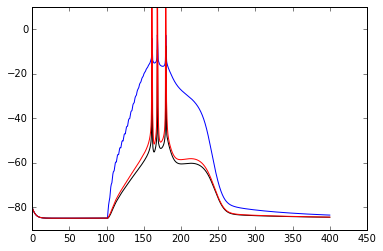

In [17]:

# delete old receptors
ampa = None
nmda = None

# add new receptors

# create synapse
syn         = h.glutamate(x, sec=sec)
syn.ratio   = 1.0/3.0


# create NetStim object
stim            = h.NetStim()
stim.number     = 20
stim.start      = 100
stim.interval   = 1000/300 # mean interval between two spikes in ms (1000 / 300 Hz)
#stim.noise      = 1.0


#vecStim = h.VecStim()
#vec = h.Vector([100, 120])
#vecStim.play(vec)


# create NetCon object
#ncon             = h.NetCon(stim,syn) 
ncon             = h.NetCon(stim, syn)
ncon.delay       = 1
ncon.weight[0]   = 1.5e-3 # (uS) = 1.5 nS

h.finitialize(vinit)
while h.t < tstop:
    h.fadvance()
    
plt.figure()   
plt.plot(tm,vmL, 'b')
plt.plot(tm,vmS, 'k')
plt.plot(tm,vm, 'r')
plt.ylim(-90, 10)
plt.show()

**Spikes with both the updated and old stimulation mechanism**

## Full morphology from the GENESIS model
The morphology

    msn_corrected.swc
        
as well as the morphologies containing single stems used above, are all made using the Matlab toolbox I created in my master thesis. For this aim a new function for writing to swc format were implemented, together with minor updates to other scrips (e.g. the type field were also recorded during import). Since the toolbox reduces the number of nodes in morphology file, the raw file were also tested with (almost?) identical results.

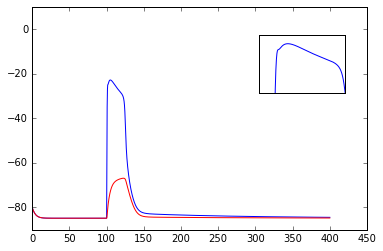

In [18]:
%reset -f

%matplotlib inline

from    neuron  import          h
import  numpy                as np
import  matplotlib.pyplot    as plt
import  matplotlib.image     as mpimg
import  json

from mpl_toolkits.axes_grid.inset_locator import inset_axes

# Load model mechanisms
import neuron               as nrn
nrn.load_mechanisms('Mech/')

h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')


vinit  = -80
tstop  = 400
use_Ca = True


def calculate_distribution(d3, dist, a4, a5,  a6,  a7, g8):
    '''
    Used for setting the maximal conductance of a segment.
    Scales the maximal conductance based on somatic distance and distribution type.
    
    Parameters:
    d3   = distribution type:
         0 linear, 
         1 sigmoidal, 
         2 exponential
         3 step function
    dist = somatic distance of segment
    a4-7 = distribution parameters 
    g8   = base conductance (similar to maximal conductance)
    
    '''
    
    if   d3 == 0: 
        value = a4 + a5*dist
    elif d3 == 1: 
        value = a4 + a5/(1 + np.exp((dist-a6)/a7) )
    elif d3 == 2: 
        value = a4 + a5*np.exp((dist-a6)/a7)
    elif d3 == 3:
        if (dist > a6) and (dist < a7):
            value = a4
        else:
            value = a5
            
    if value < 0:
        value = 0
        
    value = value*g8
    return value 






# copy this part to notebook |
#                            v


# import morphology (full stem; 8 or 10) --------------------------------------

Import = h.Import3d_SWC_read()
Import.input('msn_corrected.swc') #'stem10_msn_corrected.swc'
imprt = h.Import3d_GUI(Import, 0)
imprt.instantiate(None)
h.define_shape()

# make list of all dendritic sections
dendlist = h.SectionList()

for sec in h.allsec():
    if   'soma' in sec.name():
        soma = sec
    elif 'dend' in sec.name():
        dendlist.append(sec=sec)


#h.topology()




# set number of segments per section
for sec in dendlist:    
    sec.nseg = 2*int(sec.L/10.0)+1




# set biophysical properties ---------------------------------------------
    
casc    =   h.D1_reduced_cascade2_0(0.5, sec=sec) 
pointer =   casc._ref_Target1p   

with open('params_dMSN.json') as file:
    par = json.load(file)

somaChannels = [    "naf",      
                    "kaf",
                    "kas",
                    "kdr",
                    "kir",
                    "sk",
                    "bk"            ]
if use_Ca:
    somaChannels = somaChannels + [     "cal12",
                                        "cal13",
                                        "can",
                                        "car",
                                        "cav32",
                                        "cav33",
                                        "cadyn", 
                                        "caldyn"    ]


# set soma as reference for distance mesurement
h.distance(0, 1.0, sec=sec)


for sec in h.allsec():
    
    # active properties
    if 'soma' in sec.name():
        
        for mech in somaChannels:
            sec.insert(mech)
            
        cmd = 'sec(0.5).gbar_naf = float(par["gbar_naf_somatic"]["Value"])'
        exec(cmd)
        cmd = 'sec(0.5).gbar_kaf = float(par["gbar_kaf_somatic"]["Value"])'
        exec(cmd)   
        cmd = 'sec(0.5).gbar_kas = float(par["gbar_kas_somatic"]["Value"])'
        exec(cmd) 
        cmd = 'sec(0.5).gbar_kir = float(par["gbar_kir_somatic"]["Value"])'
        exec(cmd) 
        cmd = 'sec(0.5).gbar_sk = float(par["gbar_sk_somatic"]["Value"])'
        exec(cmd)
        cmd = 'sec(0.5).gbar_bk = float(par["gbar_bk_somatic"]["Value"])'
        
        if use_Ca:
            exec(cmd)
            cmd = 'sec(0.5).pbar_cal12 = 1e-5'
            exec(cmd)
            cmd = 'sec(0.5).pbar_cal13 = 1e-6'
            exec(cmd)
            cmd = 'sec(0.5).pbar_car = 1e-4'
            exec(cmd)
            cmd = 'sec(0.5).pbar_can = 1e-7'
    
    else:
        for mech in somaChannels+["cav32", "cav33"]:
            sec.insert(mech)
        for seg in sec:
            
            dist = h.distance(seg.x, sec=sec)
            
            #if dist > 100:
            #    print dist, sec.name(), seg.x
            
            cmd = 'sec(seg.x).gbar_naf = calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
            exec(cmd)
            cmd = 'sec(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
            exec(cmd)   
            cmd = 'sec(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
            exec(cmd) 
            cmd = 'sec(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
            exec(cmd) 
            cmd = 'sec(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
            exec(cmd)
            cmd = 'sec(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
            exec(cmd)
            
            if use_Ca:
                cmd = 'sec(seg.x).pbar_cal12 = 1e-5'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_cal13 = 1e-6'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_car = 1e-4'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_can = 1e-7'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
                exec(cmd)
    
    
    # set pointers
    for seg in sec:
        for mech in seg:
            if mech.name() in [ "kaf", \
                                "kas", \
                                "naf", \
                                "kir"       ]:
                h.setpointer( pointer, 'pka', mech )
                
            elif mech.name() in [   "cal12", \
                                    "cal13", \
                                    "can"           ]:
                if use_Ca:
                    h.setpointer( pointer, 'pka', mech )
            
                
    
    
    
    # passive properties
    sec.insert('pas')
    sec.g_pas = 1e-5
    sec.e_pas = -80
    sec.cm    = 1.0
    sec.Ra    = 150
    sec.ena   = 50
    sec.ek    = -85 # -90





# simulate
x = 0.9
s = 'dend[90]'

for sec in h.allsec():
    if sec.name() == s:
        break


# max receptor current (uS). 
ampa_max = 20e-3                # ~20 ampa synapses in genesis model (1 = 510 pS)
nmda_max = 60e-3                #                      genesis model (1 = 1410 ps)

# insert receptors (activated after 100 ms)
ampa       = h.ampa(x, sec=sec)
ampa.onset = 100
ampa.gmax  = ampa_max
nmda       = h.nmda(x, sec=sec)
nmda.onset = 100
nmda.gmax  = nmda_max


# record vectors
vm = h.Vector()
vm.record(soma(0.5)._ref_v)
vmL = h.Vector()
vmL.record(sec(x)._ref_v)
tm  = h.Vector()
tm.record(h._ref_t)

h.finitialize(vinit)
while h.t < tstop:
    h.fadvance()
    
plt.figure()   
plt.plot(tm,vmL, 'b')
#plt.plot(tm,vmS, 'k')
plt.plot(tm,vm, 'r')
plt.ylim(-90, 10)
ax2 = plt.axes([.65, .6, .2, .2])
ax2.plot(tm,vmL)
plt.setp(ax2, ylim=(-40, -20), xlim=(95,125), xticks=[], yticks=[])
plt.show()

### WIth updated synaptic mechanism

dend[123]
dend[102]
dend[95]
dend[66]
dend[45]
dend[36]
dend[27]
dend[24]
dend[15]
dend[0]


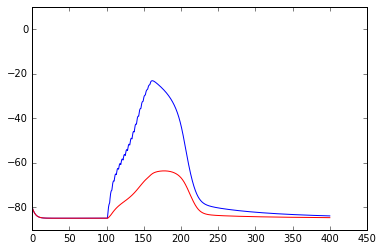

In [19]:

# delete old receptors
ampa = None
nmda = None

# add new receptors

# create synapse
syn         = h.glutamate(x, sec=sec)
syn.ratio   = 1.0/3.0


# create NetStim object
stim            = h.NetStim()
stim.number     = 20
stim.start      = 100
stim.interval   = 1000/300 # mean interval between two spikes in ms (1000 / 300 Hz)
#stim.noise      = 1.0


#vecStim = h.VecStim()
#vec = h.Vector([100, 120])
#vecStim.play(vec)


# create NetCon object
#ncon             = h.NetCon(stim,syn) 
ncon             = h.NetCon(stim, syn)
ncon.delay       = 1
ncon.weight[0]   = 1.5e-3 # (uS) = 1.5 nS

h.finitialize(vinit)
while h.t < tstop:
    h.fadvance()

for stem in soma.children():
    print stem.name()
    
plt.figure()   
plt.plot(tm,vmL, 'b')
plt.plot(tm,vm, 'r')
plt.ylim(-90, 10)
plt.show()

**So with the full morphology the cell behave similar to the GENESIS version and do not spike!**

## Removing branches one at the time
Stimulating either 10 or 8 from the original morphology (Kai used branch 8), while sequetially removing one branch at the time (choosen randomly).
Printing all the root section of the neurites 


    soma.children(), (where soma is a reference to the soma section)


shows that sections 66-94 and 102-121 belongs to stem 8 and 10, respectively. Further, by using the distance function 

    h.distance() 
        
that node 0.9 of section 90 has a somatic distance of about 112 $\mu$m and node 0.71 of the 108 section has a distance of 121 $\mu$m. <br>

If the cell spikes, the simulation stops and no further branches are removed.

dend[123]
dend[102]
dend[95]
dend[66]
dend[45]
dend[36]
dend[27]
dend[24]
dend[15]
dend[0]
0 -removing stem: dend[0] mother stem: dend[66]
1 -removing stem: dend[123] mother stem: dend[66]
2 -removing stem: dend[45] mother stem: dend[66]
dend[45]
dend[123]
dend[0]
dend[102]
dend[95]
dend[66]
dend[36]
dend[27]
dend[24]
dend[15]
0 -removing stem: dend[45] mother stem: dend[102]
1 -removing stem: dend[27] mother stem: dend[102]
2 -removing stem: dend[24] mother stem: dend[102]
3 -removing stem: dend[66] mother stem: dend[102]


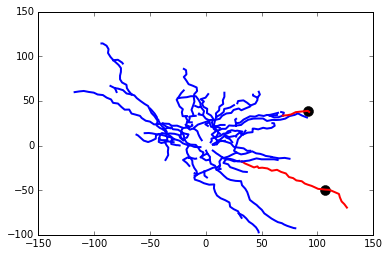

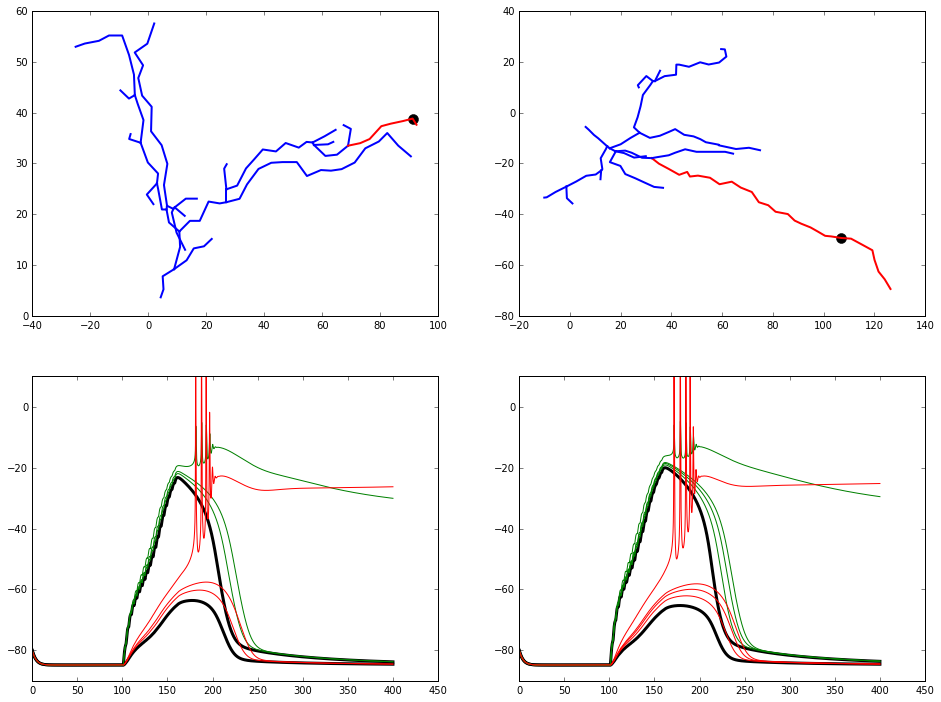

In [20]:

import  common_functions     as use

# plot full morphology
fig,ax = plt.subplots(1,1, figsize=(6,4))
target = {'dend[90]':0.9, 'dend[108]':0.71}


for stem in soma.children():  
    use.plot_morphology(stem,           \
                        ax=ax,          \
                        target=target   )

fig, ax = plt.subplots(2,2, figsize=(16,12) )

for l in range(2):
    
    removed_stems = []
    
    for stem in soma.children():
        print stem.name()
    
    if l == 0:
        mother_stem = 'dend[66]'
        
    elif l == 1:
        x = 0.71
        s = 'dend[108]'
        for sec in h.allsec():
            if sec.name() == s:
                break
        
        # relocate synapse and record vector   
        syn.loc(sec(x))
        vmL = h.Vector()
        vmL.record(sec(x)._ref_v)
        
        mother_stem = 'dend[102]'
    
    for sec in h.allsec():
        if sec.name() == mother_stem:
            
            use.plot_morphology(sec,         \
                                ax=ax[0,l],     \
                                target=target   )  
            break
            
         

    h.finitialize(vinit)
    while h.t < tstop:
        h.fadvance()
        
    ax[1,l].plot(tm,vmL, 'k', lw=3)
    ax[1,l].plot(tm,vm,  'k', lw=3)


    i = 0
    while i < len(soma.children())-1:
        
        randint = np.random.randint( len(soma.children()) )
        if soma.children()[randint].name() == mother_stem:
            continue
            
        print i, '-removing stem:', soma.children()[randint].name(), 'mother stem:', mother_stem
        
        removed_stems.append(soma.children()[randint])
        i+=1
        
        h.disconnect(sec=soma.children()[randint])
        
        
        h.finitialize(vinit)
        while h.t < tstop:
            h.fadvance()
            
        ax[1,l].plot(tm,vmL, 'g')
        ax[1,l].plot(tm,vm,  'r')
        
        
        if len(use.getSpikedata_x_y(tm,vm)) > 0:
            break
            
    
    ax[1,l].set_ylim(-90, 10)
    
    
    # reconnect disconnected stems
    for stem in removed_stems:
        stem.connect(soma(0.5))
    
    
plt.show()

### Calculate and plot axial currents
The simulation is done in the following way:

* The membrane potential of the soma and all its child nodes are recorded (using the commonFunctions.py function
    **AXIAL = record_axial_current(node)**)
* After simulation all axial currents flowing out from the soma are calculated using Ohm's law as; $\frac{soma-node_i}{ri_i}$,
        
where $ri_i$ is the axial resistance of node ***i***. This is all done by 
**plot_axial_current( AXIAL, tm, vm, ax )** <br>


For the current plots the trace icluding spikes is not plotted in one to make it easier to see the non spiking traces.

0 -removing stem: dend[27] mother stem: dend[66]
1 -removing stem: dend[123] mother stem: dend[66]
2 -removing stem: dend[45] mother stem: dend[66]
0 -removing stem: dend[95] mother stem: dend[102]
1 -removing stem: dend[36] mother stem: dend[102]
2 -removing stem: dend[45] mother stem: dend[102]
3 -removing stem: dend[123] mother stem: dend[102]


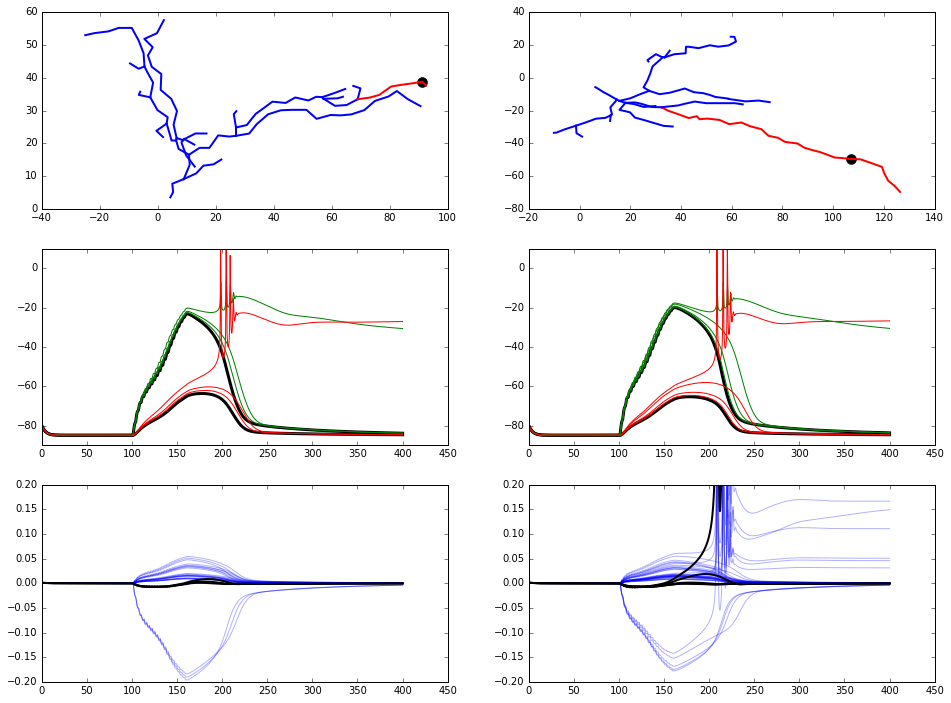

In [27]:
fig, ax = plt.subplots( 3,2, figsize=(16,12) )



for l in range(2):
    
    removed_stems = []
        
        
    if l == 0:
        x = 0.9
        s = 'dend[90]'
        mother_stem = 'dend[66]'
    elif l == 1:
        x = 0.71
        s = 'dend[108]'
        mother_stem = 'dend[102]'
    
    # relocate synapse and record vector
    for sec in h.allsec():
        if sec.name() == s:
            syn.loc(sec(x))
            vmL = h.Vector()
            vmL.record(sec(x)._ref_v)
            break
    
    # plot morphology and make sec the mother_stem (so that it is not disconnected)
    for sec in h.allsec():
        if sec.name() == mother_stem:
            
            use.plot_morphology(sec,         \
                                ax=ax[0,l],     \
                                target=target   )  
            break
            

    
    # record axial current flowing from the soma compartment  
    AXIAL = use.record_axial_current(soma)
         

    h.finitialize(vinit)
    while h.t < tstop:
        h.fadvance()
        
    ax[1,l].plot(tm,vmL, 'k', lw=3)
    ax[1,l].plot(tm,vm,  'k', lw=3)
    
    
    use.plot_axial_current( AXIAL, tm, vm, ax[2,l] )


    i = 0
    while i < len(soma.children())-1:
        
        randint = np.random.randint( len(soma.children()) )
        
        # perhaps this should be replaced with a while loop and resample the branch to disconnect
        # as it is now all branches might not be removed.
        if soma.children()[randint].name() == mother_stem:
            continue
            
        print i, '-removing stem:', soma.children()[randint].name(), 'mother stem:', mother_stem
        
        removed_stems.append(soma.children()[randint])
        i+=1
        
        h.disconnect(sec=soma.children()[randint])
        
        # record axial current flowing from the soma compartment  
        AXIAL = use.record_axial_current(soma)
        
        h.finitialize(vinit)
        while h.t < tstop:
            h.fadvance()
            
        ax[1,l].plot(tm,vmL, 'g')
        ax[1,l].plot(tm,vm,  'r')
        
        
        if len(use.getSpikedata_x_y(tm,vm)) > 0:
            if l == 1:
                use.plot_axial_current( AXIAL, tm, vm, ax[2,l] )
            break
            
        use.plot_axial_current( AXIAL, tm, vm, ax[2,l] )
    
    ax[1,l].set_ylim(-90, 10)
    ax[2,l].set_ylim(-0.2, 0.2)
    
    
    # reconnect disconnected stems
    for stem in removed_stems:
        stem.connect(soma(0.5))
    
    
plt.show()

## With D1 morphology from Frontiers paper (Lindroos et al 2018)

Mechanisms already loaded from path: Mech/.  Aborting.
dend[57] 154.91212732


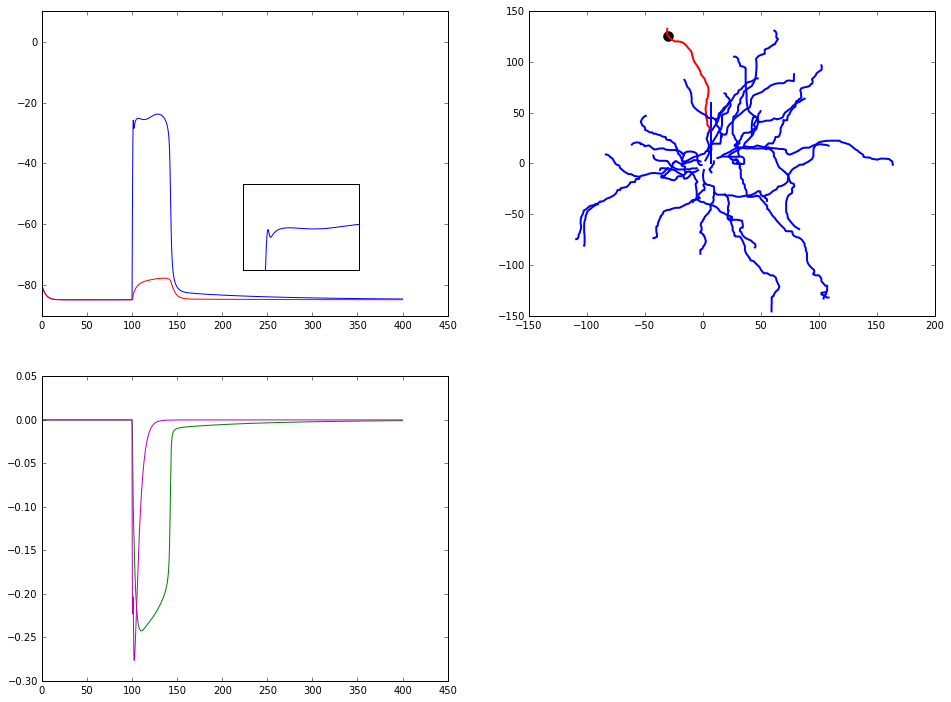

In [7]:
%reset -f

%matplotlib inline

from    neuron  import          h
import  numpy                as np
import  matplotlib.pyplot    as plt
import  matplotlib.image     as mpimg
import  json

from mpl_toolkits.axes_grid.inset_locator import inset_axes

# Load model mechanisms
import neuron               as nrn
nrn.load_mechanisms('Mech/')

h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')


vinit  = -80
tstop  = 400
use_Ca = True


def calculate_distribution(d3, dist, a4, a5,  a6,  a7, g8):
    '''
    Used for setting the maximal conductance of a segment.
    Scales the maximal conductance based on somatic distance and distribution type.
    
    Parameters:
    d3   = distribution type:
         0 linear, 
         1 sigmoidal, 
         2 exponential
         3 step function
    dist = somatic distance of segment
    a4-7 = distribution parameters 
    g8   = base conductance (similar to maximal conductance)
    
    '''
    
    if   d3 == 0: 
        value = a4 + a5*dist
    elif d3 == 1: 
        value = a4 + a5/(1 + np.exp((dist-a6)/a7) )
    elif d3 == 2: 
        value = a4 + a5*np.exp((dist-a6)/a7)
    elif d3 == 3:
        if (dist > a6) and (dist < a7):
            value = a4
        else:
            value = a5
            
    if value < 0:
        value = 0
        
    value = value*g8
    return value 


def plot_morphology(stem, \
                    ax=False, \
                    target=[]):
    
    if not ax:
        fig,ax = plt.subplots(1,1)
    
    # get subtree (wholetree could possibly also be used).
    tree = h.SectionList()
    tree.subtree(sec=stem)
    
    
    
    # loop over sections
    for sec in tree:
        
        x = []
        y = []
        z = []
        
        arc = []
        
        # loop over segments in section (including 0 and 1)
        for i in range( int(h.n3d(sec=sec)) ):
            
            # collect 3d points 
            x.append( h.x3d(i, sec=sec) )
            y.append( h.y3d(i, sec=sec) )
            z.append( h.z3d(i, sec=sec) )
            
            arc.append( h.arc3d(i, sec=sec) )
            
        if sec.name() in target:
            c = 'r'
            i = next( i[0] for i in enumerate(arc) if i[1] > sec.L*target[sec.name()] )
            ax.plot(x[i], y[i], 'o', color='k', ms=10)
        else:
            c = 'b'
                
        # plot section
        ax.plot(x, y, color=c, lw=2)
        
        
    if ax:
        return ax
    else:
        fig.show()

# copy this part to notebook |
#                            v


# import morphology (full stem; 8 or 10) --------------------------------------

Import = h.Import3d_SWC_read()
Import.input('WT-dMSN_P270-20_1.02_SGA1-m24.swc') # Morphology used in Lindroos et al., 2018
imprt = h.Import3d_GUI(Import, 0)
imprt.instantiate(None)
h.define_shape()

# make list of all dendritic sections
dendlist = h.SectionList()

for sec in h.allsec():
    if   'soma' in sec.name():
        soma = sec
    elif 'dend' in sec.name():
        dendlist.append(sec=sec)


#h.topology()




# set number of segments per section
for sec in dendlist:    
    sec.nseg = 2*int(sec.L/10.0)+1




# set biophysical properties ---------------------------------------------
    
casc    =   h.D1_reduced_cascade2_0(0.5, sec=sec) 
pointer =   casc._ref_Target1p   

with open('params_dMSN.json') as file:
    par = json.load(file)

somaChannels = [    "naf",      
                    "kaf",
                    "kas",
                    "kdr",
                    "kir",
                    "sk",
                    "bk"            ]
if use_Ca:
    somaChannels = somaChannels + [     "cal12",
                                        "cal13",
                                        "can",
                                        "car",
                                        "cav32",
                                        "cav33",
                                        "cadyn", 
                                        "caldyn"    ]


# set soma as reference for distance mesurement
h.distance(0, 1.0, sec=soma)


for sec in h.allsec():
    
    # active properties
    if 'soma' in sec.name():
        
        for mech in somaChannels:
            sec.insert(mech)
            
        cmd = 'sec(0.5).gbar_naf = float(par["gbar_naf_somatic"]["Value"])'
        exec(cmd)
        cmd = 'sec(0.5).gbar_kaf = float(par["gbar_kaf_somatic"]["Value"])'
        exec(cmd)   
        cmd = 'sec(0.5).gbar_kas = float(par["gbar_kas_somatic"]["Value"])'
        exec(cmd) 
        cmd = 'sec(0.5).gbar_kir = float(par["gbar_kir_somatic"]["Value"])'
        exec(cmd) 
        cmd = 'sec(0.5).gbar_sk = float(par["gbar_sk_somatic"]["Value"])'
        exec(cmd)
        cmd = 'sec(0.5).gbar_bk = float(par["gbar_bk_somatic"]["Value"])'
        
        if use_Ca:
            exec(cmd)
            cmd = 'sec(0.5).pbar_cal12 = 1e-5'
            exec(cmd)
            cmd = 'sec(0.5).pbar_cal13 = 1e-6'
            exec(cmd)
            cmd = 'sec(0.5).pbar_car = 1e-4'
            exec(cmd)
            cmd = 'sec(0.5).pbar_can = 1e-7'
    
    else:
        for mech in somaChannels+["cav32", "cav33"]:
            sec.insert(mech)
        for seg in sec:
            
            dist = h.distance(seg.x, sec=sec)
            
            #if dist > 100:
            #    print dist, sec.name(), seg.x
            
            cmd = 'sec(seg.x).gbar_naf = calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
            exec(cmd)
            cmd = 'sec(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
            exec(cmd)   
            cmd = 'sec(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
            exec(cmd) 
            cmd = 'sec(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
            exec(cmd) 
            cmd = 'sec(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
            exec(cmd)
            cmd = 'sec(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
            exec(cmd)
            
            if use_Ca:
                cmd = 'sec(seg.x).pbar_cal12 = 1e-5'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_cal13 = 1e-6'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_car = 1e-4'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_can = 1e-7'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
                exec(cmd)
                cmd = 'sec(seg.x).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
                exec(cmd)
    
    
    # set pointers
    for seg in sec:
        for mech in seg:
            if mech.name() in [ "kaf", \
                                "kas", \
                                "naf", \
                                "kir"       ]:
                h.setpointer( pointer, 'pka', mech )
                
            elif mech.name() in [   "cal12", \
                                    "cal13", \
                                    "can"           ]:
                if use_Ca:
                    h.setpointer( pointer, 'pka', mech )
            
                
    
    
    
    # passive properties
    sec.insert('pas')
    sec.g_pas = 1e-5
    sec.e_pas = -80
    sec.cm    = 1.0
    sec.Ra    = 150
    sec.ena   = 50
    sec.ek    = -85 # -90





# simulate
x = 0.9
s = 'dend[57]'

for sec in h.allsec():
    if sec.name() == s:
        print sec.name(), h.distance(x, sec=sec)
        break


# max receptor current (uS). 
ampa_max = 10e-3                # ~20 ampa synapses in genesis model (1 = 510 pS)
nmda_max = 30e-3                #                      genesis model (1 = 1410 ps)

# insert receptors (activated after 100 ms)
ampa       = h.ampa(x, sec=sec)
ampa.onset = 100
ampa.gmax  = ampa_max
nmda       = h.nmda(x, sec=sec)
nmda.onset = 100
nmda.gmax  = nmda_max
nmda.tau1  = 5.63/2.0       # same as kai (Du et al., 2017)
nmda.tau2  = 231.0/2.0      # same as kai 
nmda.mg    = 1
nmda.alpha = 0.08

# record vectors
vm = h.Vector()
vm.record(soma(0.5)._ref_v)
vmL = h.Vector()
vmL.record(sec(x)._ref_v)
tm  = h.Vector()
tm.record(h._ref_t)

NMDA = h.Vector()
NMDA.record(nmda._ref_i)
AMPA = h.Vector()
AMPA.record(ampa._ref_i)

h.finitialize(vinit)
while h.t < tstop:
    h.fadvance()

    
target = {s:x}

fig, ax = plt.subplots(2,2, figsize=(16,12) )

for stem in soma.children():  
    plot_morphology(stem,           \
                    ax=ax[0,1],       \
                    target=target   )

ax[0,0].plot(tm,vmL, 'b')
#plt.plot(tm,vmS, 'k')
ax[0,0].plot(tm,vm, 'r')
ax[0,0].set_ylim(-90, 10)
ax2 = plt.axes([.3, .6, .1, .1])
ax2.plot(tm,vmL)
plt.setp(ax2, ylim=(-40, -10), xlim=(95,125), xticks=[], yticks=[])
ax[1,0].plot(tm, NMDA, color='g')
ax[1,0].plot(tm, AMPA, color='m')
ax[1,1].axis('off')
plt.show()

### With updated synaptic mechanism--1 strong activation

axon[0]
dend[55]
dend[54]
dend[49]
dend[42]
dend[31]
dend[30]
dend[19]
dend[0]


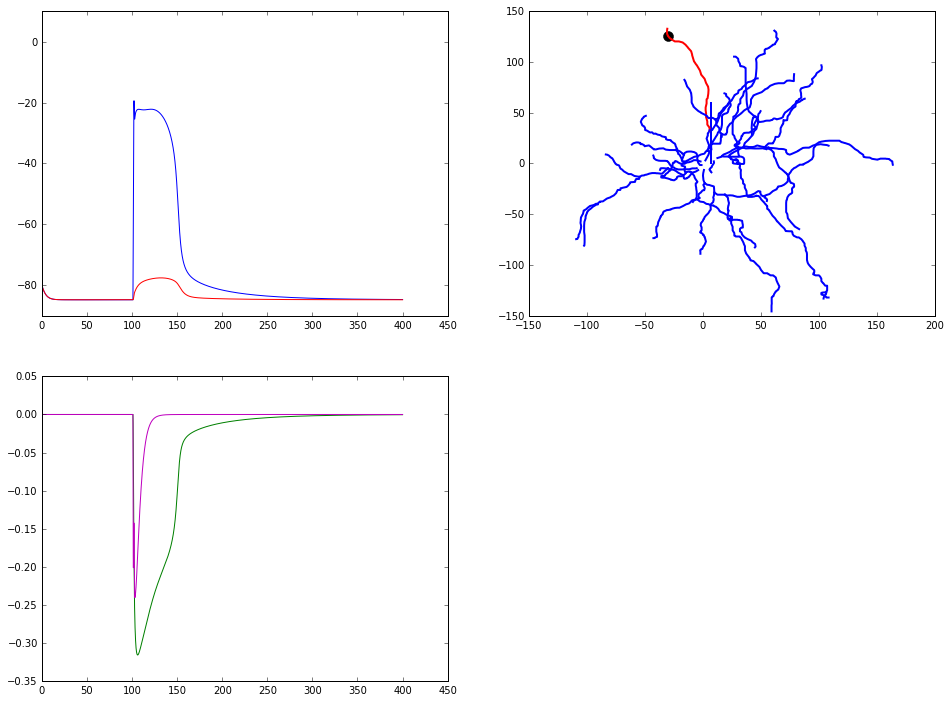

In [2]:
# delete old receptors
ampa = None
nmda = None

# add new receptors

# create synapse
syn         = h.glutamate(x, sec=sec)
syn.ratio   = 1.0/3.0

# time constants
syn.tau1_nmda = 5.63/2.0
syn.tau2_nmda = 231.0/2.0


# create NetStim object
stim            = h.NetStim()
stim.number     = 1
stim.start      = 100
stim.interval   = 2 # mean interval between two spikes in ms (1000 / 300 Hz)
#stim.noise      = 1.0


#vecStim = h.VecStim()
#vec = h.Vector([100, 120])
#vecStim.play(vec)


# create NetCon object
#ncon             = h.NetCon(stim,syn) 
ncon             = h.NetCon(stim, syn)
ncon.delay       = 1
ncon.weight[0]   = 30.0e-3 # (uS) = 1.5 nS

NMDA = h.Vector()
NMDA.record(syn._ref_i_nmda)
AMPA = h.Vector()
AMPA.record(syn._ref_i_ampa)

h.finitialize(vinit)
while h.t < tstop:
    h.fadvance()

for stem in soma.children():
    print stem.name()

fig, ax = plt.subplots(2,2, figsize=(16,12) )

for stem in soma.children():  
    plot_morphology(stem,           \
                    ax=ax[0,1],       \
                    target=target   )

ax[0,0].plot(tm,vmL, 'b')
#plt.plot(tm,vmS, 'k')
ax[0,0].plot(tm,vm, 'r')
ax[0,0].set_ylim(-90, 10)
ax[1,0].plot(tm, NMDA, color='g')
ax[1,0].plot(tm, AMPA, color='m')
ax[1,1].axis('off')
plt.show()

### 20 synapses with ISI 0.01 ms (same strength as Genesis)

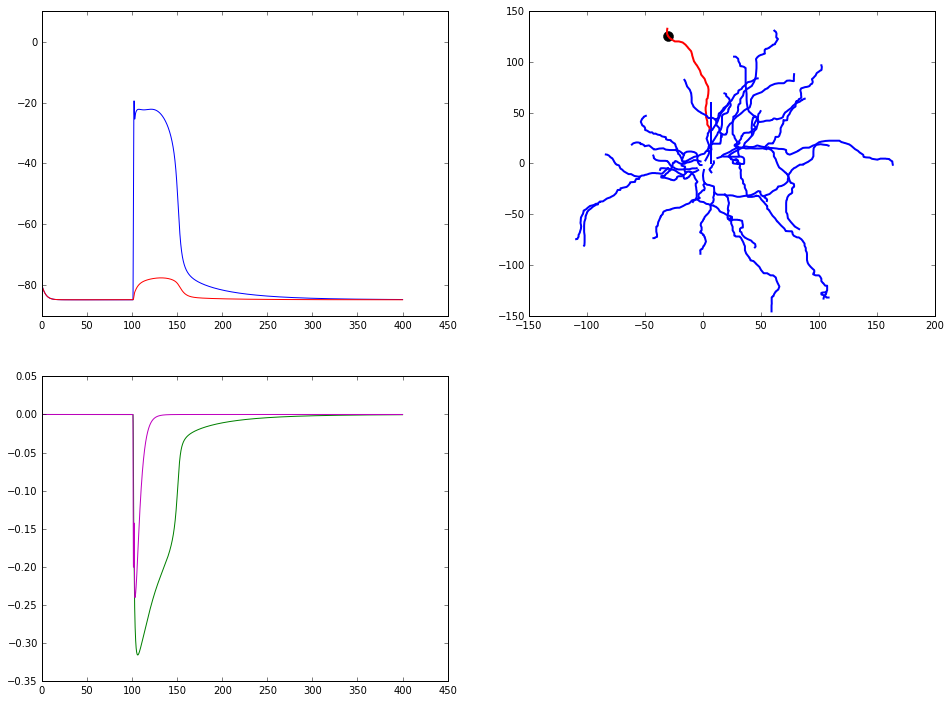

In [3]:
stim.interval   = 0.01 # mean interval between two spikes in ms (1000 / 300 Hz)
stim.number     = 20
ncon.weight[0]  = 1.5e-3 # (uS) = 1.5 nS

h.finitialize(vinit)
while h.t < tstop:
    h.fadvance()

fig, ax = plt.subplots(2,2, figsize=(16,12) )

for stem in soma.children():  
    plot_morphology(stem,           \
                    ax=ax[0,1],       \
                    target=target   )

ax[0,0].plot(tm,vmL, 'b')
#plt.plot(tm,vmS, 'k')
ax[0,0].plot(tm,vm, 'r')
ax[0,0].set_ylim(-90, 10)
ax[1,0].plot(tm, NMDA, color='g')
ax[1,0].plot(tm, AMPA, color='m')
ax[1,1].axis('off')
plt.show()

### with ISI 1 ms

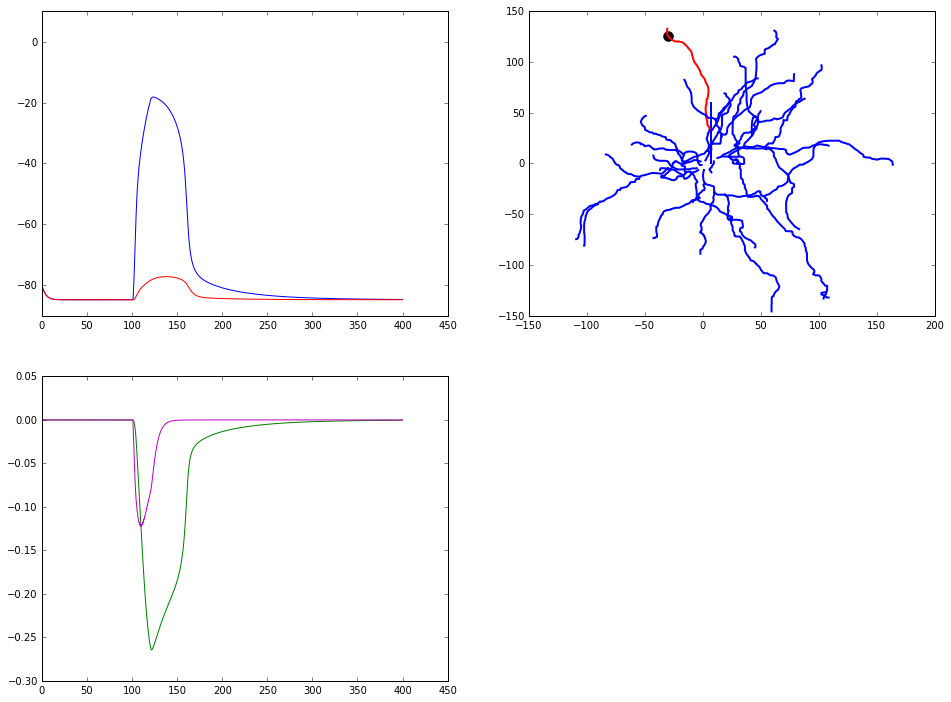

In [4]:
stim.interval   = 1 # mean interval between two spikes in ms (1000 / 300 Hz)

h.finitialize(vinit)
while h.t < tstop:
    h.fadvance()

fig, ax = plt.subplots(2,2, figsize=(16,12) )

for stem in soma.children():  
    plot_morphology(stem,           \
                    ax=ax[0,1],       \
                    target=target   )

ax[0,0].plot(tm,vmL, 'b')
#plt.plot(tm,vmS, 'k')
ax[0,0].plot(tm,vm, 'r')
ax[0,0].set_ylim(-90, 10)
ax[1,0].plot(tm, NMDA, color='g')
ax[1,0].plot(tm, AMPA, color='m')
ax[1,1].axis('off')
plt.show()

### ISI = 2 ms

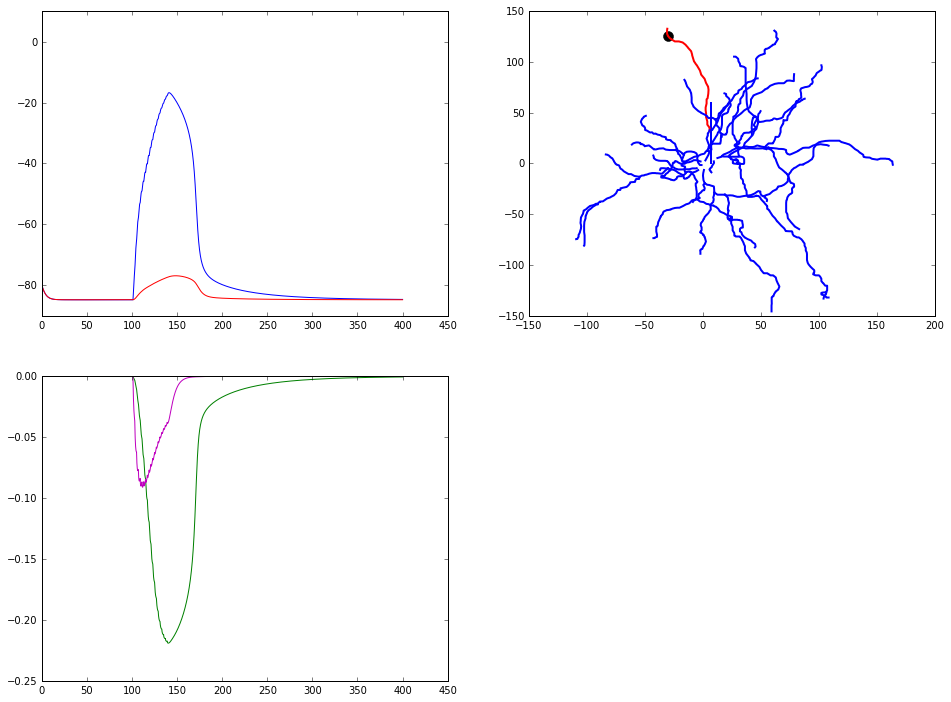

In [5]:
stim.interval   = 2 # mean interval between two spikes in ms (1000 / 300 Hz)

h.finitialize(vinit)
while h.t < tstop:
    h.fadvance()

fig, ax = plt.subplots(2,2, figsize=(16,12) )

for stem in soma.children():  
    plot_morphology(stem,           \
                    ax=ax[0,1],       \
                    target=target   )

ax[0,0].plot(tm,vmL, 'b')
#plt.plot(tm,vmS, 'k')
ax[0,0].plot(tm,vm, 'r')
ax[0,0].set_ylim(-90, 10)
ax[1,0].plot(tm, NMDA, color='g')
ax[1,0].plot(tm, AMPA, color='m')
ax[1,1].axis('off')
plt.show()

## Dynamic clamp

## Local input resistance

In [34]:
# # relocate synaptic activation outside of current morphology
# sink = h.Section( name='sink' )
# syn.loc( sink(x) )

# # initiate clamp
# stim        =   h.IClamp(0.5, sec=soma)
# stim.amp    =   50e-3 # 50 pA
# stim.delay  =   100    #ms
# stim.dur    =   500

# # initiate result structures
# #res = {}
# D   = []
# R   = []

# # loop over sections
# for sec in h.allsec():
    
#     # don't record in sink
#     if 'sink' in sec.name():
#         continue
        
#     # move clamp to center of section
#     stim.loc( sink(x) )
    
#     # record local membrane potential
#     vml = h.Vector()
#     vml.record( sec(0.5)._ref_v )
    
#     # run
#     h.finitialize(vinit)
#     while h.t < tstop:
#         h.fadvance()
    
#     # calc Rin and somatic deflection
#     i = next(x[0] for x in enumerate(tm) if x[1] > 95)
#     Rin = (vml[-1]-vml[i]) / stim.amp
    
#     # save result structure
#     dist     = h.distance(0.5, sec=sec)
#     #res[sec] = {'dist': dist, 'Rin': Rin}
#     D.append(dist)
#     R.append(Rin)
    
# # sort on distance
# index = np.argsort(dist)

# x = [D[i] for i in index]
# y = [R[i] for i in index]

# # plot
# plt.plot(x,y, 'o', ms=10, alpha=0.3, color='b')


KeyboardInterrupt: 

## Add spine

## Cell class

In [ ]:

# Cell class, similar to neuron ball-and-stick example
#             https://www.neuron.yale.edu/neuron/static/docs/neuronpython/ballandstick2.html
#             and Lindroos et al., 2018
class cell():
    
    def __init__(self, 
                 parameters={   'soma':{'L':12.2, 'diam':12.2, 'nseg':1}, 
                                'dend':{'L':12.2, 'diam':12.2, 'nseg':1}, 
                                'pas' :{'Ra':150, 'Cm':1, 'Erev':-80, 'gpas':1e-5}
                             }, 
                 params='params_dMSN.json'
                ):
        
        self.somaChan = [       "naf",
                                "kaf",
                                "kas",
                                "kdr",
                                "kir",
                                "cal12",
                                "cal13",
                                "can",
                                "car",
                                "sk",
                                "bk"        ]

            
        # create soma
        self.soma = h.Section(name='soma')
        self.dend = h.Section(name='dend')

        # connect the two sections
        self.dend.connect(self.soma(1))

        # size and number of segments of compartments
        self.soma.L         = parameters['soma']['L']
        self.soma(0.5).diam = parameters['soma']['diam']
        self.soma.nseg      = parameters['soma']['nseg']

        self.dend.L         = parameters['dend']['L']
        self.dend(0.5).diam = parameters['dend']['diam']
        self.dend.nseg      = parameters['soma']['nseg']

        # Axial resistance etc
        self.Ra   = parameters['pas']['Ra']
        self.Cm   = parameters['pas']['Cm']
        self.Erev = parameters['pas']['Erev']
        self.gpas = parameters['pas']['gpas']
        
        
        if 'Sink' in parameters:
            add_Sink_node(self,
                          parameters['Sink']
                         )

        # insert mechanisms (ion channels etc)
        casc    =   h.D1_reduced_cascade2_0(0.5, sec=self.dend) 
        pointer =   casc._ref_Target1p   


        with open(params) as file:
            par = json.load(file)


        for sec in h.allsec():    

            # insert pas
            sec.insert('pas')
            sec.g_pas = parameters['pas']['gpas']
            sec.e_pas = parameters['pas']['Erev']
            sec.cm    = parameters['pas']['Cm']
            sec.Ra    = parameters['pas']['Ra']

            # Set conductance and pointers (needed for dynamic neuromodulation; not used here).
            for seg in sec:

                # set conductance
                if sec.name() == 'soma':
                    for mech in somaChan:
                        sec.insert(mech)

                elif sec.name() in ['dend', 'Sink']:
                    for mech in somaChan+["cav32", "cav33"]:
                        sec.insert(mech)

                for mech in seg:
                    if mech.name() in [ "kaf", \
                                        "kv4", \
                                        "kas", \
                                        "naf", \
                                        "kir", \
                                        "cal12", \
                                        "cal13", \
                                        "can"           ]:

                        h.setpointer( pointer, 'pka', mech )
            
            sec.ek  = -85
            sec.ena =  50
            
        set_conductance(self, par)
    
    def set_conductance(self, 
                        parameters,
                        par       ):
    
        cmd = 'self.soma(0.5).gbar_naf = float(par["gbar_naf_somatic"]["Value"])'
        exec(cmd)
        cmd = 'self.soma(0.5).gbar_kaf = float(par["gbar_kaf_somatic"]["Value"])'
        exec(cmd)   
        cmd = 'soma(0.5).gbar_kas = float(par["gbar_kas_somatic"]["Value"])'
        exec(cmd) 
        cmd = 'soma(0.5).gbar_kir = float(par["gbar_kir_somatic"]["Value"])'
        exec(cmd) 
        cmd = 'soma(0.5).gbar_sk = float(par["gbar_sk_somatic"]["Value"])'
        exec(cmd)
        cmd = 'soma(0.5).gbar_bk = float(par["gbar_bk_somatic"]["Value"])'
        exec(cmd)
        cmd = 'soma(0.5).pbar_cal12 = 1e-5'
        exec(cmd)
        cmd = 'soma(0.5).pbar_cal13 = 1e-6'
        exec(cmd)
        cmd = 'soma(0.5).pbar_car = 1e-4'
        exec(cmd)
        cmd = 'soma(0.5).pbar_can = 1e-7'

        dist = 115.0
        for seg in self.dend:
    
            dist = h.distance(seg.x, sec=dend)

            cmd = 'dend(seg.x).gbar_naf = 0.000001*calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
            exec(cmd)
            cmd = 'dend(seg.x).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
            exec(cmd)   
            cmd = 'dend(seg.x).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
            exec(cmd) 
            cmd = 'dend(seg.x).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
            exec(cmd) 
            cmd = 'dend(seg.x).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
            exec(cmd)
            cmd = 'dend(seg.x).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_cal12 = 1e-5'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_cal13 = 1e-6'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_car = 1e-4'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_can = 1e-10'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
            exec(cmd)
            cmd = 'dend(seg.x).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
            exec(cmd)
        
        
        if 'Sink' in parameters:
            a=changeThis
            
    
    def add_Sink_node(self,
                      Sinkpar
                     ):
        
        
        # create Sink node
        
        # specify properties
        
        # set conductances
        for seg in Sink:
    
            dist = h.distance(0.5, sec=Sink)

            cmd = 'Sink(0.5).gbar_naf = 0.0001* calculate_distribution(1, dist, 0.1, 0.9, 60.0, 10.0, float(par["gbar_naf_basal"]["Value"]))'
            exec(cmd)
            cmd = 'Sink(0.5).gbar_kaf = calculate_distribution(1, dist, 1, 0.5, 120.0, -30.0, float(par["gbar_kaf_basal"]["Value"]))'
            exec(cmd)   
            cmd = 'Sink(0.5).gbar_kas = calculate_distribution(2, dist, 0.1, 0.9, 0.0, -5.0, float(par["gbar_kas_basal"]["Value"]))'
            exec(cmd) 
            cmd = 'Sink(0.5).gbar_kir = float(par["gbar_kir_basal"]["Value"])'
            exec(cmd) 
            cmd = 'Sink(0.5).gbar_sk = float(par["gbar_sk_basal"]["Value"])'
            exec(cmd)
            cmd = 'Sink(0.5).gbar_bk = float(par["gbar_bk_basal"]["Value"])'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_cal12 = 1e-5'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_cal13 = 1e-6'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_car = 1e-4'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_can = 1e-7'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_cav32 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-7)'
            exec(cmd)
            cmd = 'Sink(0.5).pbar_cav33 = calculate_distribution(1, dist, 0, 1.0, 120.0, -30.0, 1e-8)'
            exec(cmd)
        

    def set_synpatic():

        # max receptor current (uS)
        ampa_max = 10e-3 
        nmda_max = 30e-3 

        # insert receptors (activated after 100 ms)
        ampa       = h.ampa(0.5, sec=dend)
        ampa.onset = 100
        ampa.gmax  = ampa_max
        nmda       = h.nmda(0.5, sec=dend)
        nmda.onset = 100
        nmda.gmax  = nmda_max


# create cell
'''

# record vectors
vm = h.Vector()
vm.record(dend(0.5)._ref_v)
tm  = h.Vector()
tm.record(h._ref_t)



h.finitialize(-80)
while h.t < 500:
    h.fadvance()
    
plt.plot(tm,vm)
plt.show()'''